In [1]:
import property_inference_interface
interface = property_inference_interface.PropertyInferenceInterface()

meta_params = {
    'num_of_LPs': 4,
    'size_of_train_set': 10000,
    'size_of_test_set': 100,
    'flatten': False, 
    'model_type': 'CNN',
    'adv_attack': 'i_FGSM'
}

interface.set_meta_params(meta_params)
interface.print_meta_params()

num_of_LPs           : 4
size_of_train_set    : 10000
size_of_test_set     : 100
flatten              : False
model_type           : CNN
adv_attack           : i_FGSM


In [2]:
interface.prepare_dataset()
interface.print_dataset_shape()

Train dataset
(10000, 1, 28, 28) (10000,)
Test dataset
(100, 1, 28, 28) (100,)


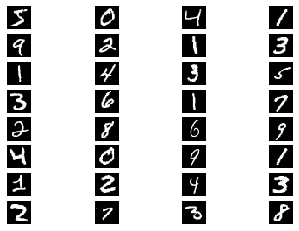

In [3]:
# Visualize the dataset
%matplotlib inline
interface.print_some_samples()

In [4]:
# interface.generate_model(num_of_epochs=15)
interface.load_model('MNIST_CNN.pt')
# interface.store_model('MNIST_CNN.pt')

interface.generate_robustified_model()
print('Display the architecture: original')
print(interface.model)
print('Display the architecture: robustified')
print(interface.robustified_model)

Display the architecture: original
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
Display the architecture: robustified
robustified_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
print('Evaluate accurancy: original')
interface.eval_model('train', on_robustified_model=False)
interface.eval_model('test', on_robustified_model=False)
print('Evaluate accurancy: robustified')
interface.eval_model('train', on_robustified_model=True)
interface.eval_model('test', on_robustified_model=True)

Evaluate accurancy: original
Model ( train ) accurancy: 0.9847
Model ( test ) accurancy: 0.98
Evaluate accurancy: robustified
Model ( train ) accurancy: 0.9719
Model ( test ) accurancy: 0.98


0.98

In [6]:
interface.generate_LPs()
interface.print_LPs()

LPs shape of 1 th class: (4,)
(1001, 9216)
(1001, 1600)
(1001, 288)
(1001, 64)
LPs shape of 2 th class: (4,)
(1127, 9216)
(1127, 1600)
(1127, 288)
(1127, 64)
LPs shape of 3 th class: (4,)
(991, 9216)
(991, 1600)
(991, 288)
(991, 64)
LPs shape of 4 th class: (4,)
(1032, 9216)
(1032, 1600)
(1032, 288)
(1032, 64)
LPs shape of 5 th class: (4,)
(980, 9216)
(980, 1600)
(980, 288)
(980, 64)
LPs shape of 6 th class: (4,)
(863, 9216)
(863, 1600)
(863, 288)
(863, 64)
LPs shape of 7 th class: (4,)
(1014, 9216)
(1014, 1600)
(1014, 288)
(1014, 64)
LPs shape of 8 th class: (4,)
(1070, 9216)
(1070, 1600)
(1070, 288)
(1070, 64)
LPs shape of 9 th class: (4,)
(944, 9216)
(944, 1600)
(944, 288)
(944, 64)
LPs shape of 10 th class: (4,)
(978, 9216)
(978, 1600)
(978, 288)
(978, 64)


In [7]:
# alphas = [.5, .4, .3, .2, 1e-1, 1e-2, 1e-3, 1e-4, 8e-5, 5e-5, 2e-5, 1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 7e-8, 5e-8, 2e-8, 1e-8, 5e-9, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16]
alphas = [1e-4]
on_robustified_model = True

for alpha in alphas:
    print('First evaluation...')
    (B_detect_ratio, A_detect_ratio), (B_LPs, A_LPs), (B_LPs_score, A_LPs_score) = interface.evaluate_algorithm_on_test_set(alpha, verbose=False, on_robustified_model=on_robustified_model)
    print('Second evaluation...')
    (B2_detect_ratio, _), (B2_LPs, _), (B2_LPs_score, _) = interface.evaluate_algorithm_on_test_set(alpha, verbose=False, dataset='train', on_robustified_model=on_robustified_model)
    # exp_info = [B2_detect_ratio, B_detect_ratio, A_detect_ratio]
    # print(alpha, exp_info)

First evaluation...


Using TensorFlow backend.


Second evaluation...


(96, 4) (98, 4) (97, 4)
This indicates the portion of inputs to be judged as "benign"
[0.96875    0.95833333 1.         0.97916667] train dataset (benign)
[0.94897959 0.95918367 0.95918367 0.97959184] test dataset (benign)
[0.20618557 0.78350515 0.5257732  0.98969072] test dataset (adversarial)


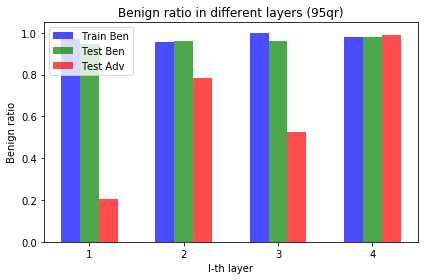

LP1
Mean: 200.01025220805778 205.4682975848231 445.72208272039074
5 qr: 133.0303904170364 126.18074534161491 208.87291344981716
50 qr: 202.1577290907651 209.79876340913773 425.6430084745763
90 qr: 237.30154839366892 251.05620316577003 697.6327913611814
95 qr: 251.88192335073563 261.1457618567104 779.2801664437256
96 qr: 255.98494542002854 263.3079176493769 796.3604278772073
97 qr: 263.38413028001884 263.89042935635797 860.1719915254238
98 qr: 280.2662652649354 266.78368228474824 886.614194915254
99 qr: 281.748206687359 277.7661338929407 1026.4443644067737
LP2
Mean: 257.286719747758 266.94284026510303 296.765687369952
5 qr: 202.34990009990008 218.14492805331315 234.7267461352207
50 qr: 253.37618343195268 267.43043934355535 299.65889830508473
90 qr: 308.1189822774125 301.6573802751494 331.02503909975206
95 qr: 314.84336775521086 312.3567690051585 340.1026105981874
96 qr: 317.5692901508429 316.3213725647329 341.3136186746769
97 qr: 324.6219249475491 322.8009385863269 347.1116204963756
98 

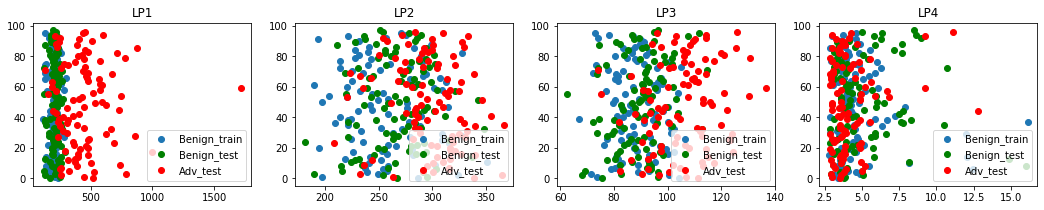

In [8]:
%matplotlib inline        
import matplotlib.pyplot as plt
import numpy as np

qr = '95'

B2LPs, BLPs, ALPs = np.array(B2_LPs), np.array(B_LPs), np.array(A_LPs) 
print(B2LPs.shape, BLPs.shape, ALPs.shape)

BLPs[BLPs=='benign'] = 1
BLPs[BLPs=='adversarial'] = 0
BLPs = BLPs.astype(np.int)
prob_BLPs = np.sum(BLPs, axis=0) / BLPs.shape[0]

B2LPs[B2LPs=='benign'] = 1
B2LPs[B2LPs=='adversarial'] = 0
B2LPs = B2LPs.astype(np.int)
prob_B2LPs = np.sum(B2LPs, axis=0) / B2LPs.shape[0]

ALPs[ALPs=='benign'] = 1
ALPs[ALPs=='adversarial'] = 0
ALPs = ALPs.astype(np.int)
prob_ALPs = np.sum(ALPs, axis=0) / ALPs.shape[0]

print('This indicates the portion of inputs to be judged as "benign"')
print(prob_B2LPs, 'train dataset (benign)')
print(prob_BLPs, 'test dataset (benign)')
print(prob_ALPs, 'test dataset (adversarial)')

# create plot
fig, ax = plt.subplots()
num_of_layers = 4
index = np.arange(num_of_layers)
bar_width = 0.2
opacity = 0.7

rects1 = plt.bar(index, prob_B2LPs, bar_width, alpha=opacity, color='b', label='Train Ben')
rects2 = plt.bar(index + bar_width, prob_BLPs, bar_width, alpha=opacity, color='g', label='Test Ben')
rects2 = plt.bar(index + 2 * bar_width, prob_ALPs, bar_width, alpha=opacity, color='r', label='Test Adv')

plt.xlabel('I-th layer')
plt.ylabel('Benign ratio')
plt.title('Benign ratio in different layers ('+qr+'qr)')
plt.xticks(index + bar_width, ('1', '2', '3', '4'))
plt.legend()

plt.tight_layout()
# plt.savefig('exp9_'+qr+'.png')
plt.show()

#-----------------------------------------------------------------------

def print_qrs(A, B, C, qrs):
    import numpy as np
    for qr in qrs:
        print(qr, 'qr:', np.percentile(A, qr), np.percentile(B, qr), np.percentile(C, qr))
    
B2LPs_score, BLPs_score, ALPs_score = np.array(B2_LPs_score), np.array(B_LPs_score), np.array(A_LPs_score) 
fig, _ = plt.subplots(nrows=1, ncols=4, figsize=(18, 3))
for i in range(BLPs_score.shape[1]):
    plt.subplot(1, 4, (i+1))
    B2LP_score, BLP_score, ALP_score = B2LPs_score[:,i], BLPs_score[:,i], ALPs_score[:,i]
    plt.plot(B2LP_score, np.arange(B2LP_score.shape[0]), 'o')
    plt.plot(BLP_score, np.arange(BLP_score.shape[0]), 'go')
    plt.plot(ALP_score, np.arange(ALP_score.shape[0]), 'ro')
    plt.legend(['Benign_train', 'Benign_test', 'Adv_test'], loc="lower right")
    plt.title('LP'+str(i+1))
    
    ##############################################
    # Compute 'mean' and '95q' in this block
    ##############################################
    print('LP'+str(i+1))
    print('Mean:', np.mean(B2LP_score), np.mean(BLP_score), np.mean(ALP_score))
    print_qrs(B2LP_score, BLP_score, ALP_score, [5, 50, 90, 95, 96, 97, 98, 99])
    ##############################################
    
# plt.savefig('exp9_01.png')
plt.show()


In [9]:
def single_exp():
    interface.generate_model(num_of_epochs=5)
    interface.generate_LPs()
    (benign_detect_ratio, adversarial_detect_ratio), (benign_LPs, adversarial_LPs) = interface.evaluate_algorithm_on_test_set(alpha, verbose=False)
    exp_info = [benign_detect_ratio, adversarial_detect_ratio]
    return exp_info    

def exp(num_of_trails, file_name):
    cumulative_exp_info = []
    
    import csv 
    for i in range(num_of_trails):
        print('trail', (i+1))
        single_exp_info = single_exp()
        cumulative_exp_info.append(single_exp_info)

        with open(file_name, mode='a', newline='') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(single_exp_info)
        file.close()

        print(single_exp_info)
        
    return cumulative_exp_info

file_name = 'test.csv'
# cumulative_exp_info = exp(40, file_name)

In [10]:
print('all pass')

all pass
